# Data Science - Scraping and visualizing car listings data

#### by Martin Josipović, Luka Dorić and Božo Marinović
<hr>

[Introduction](#introduction) -- [Web scraping](#web-scraping) -- [Data cleaning](#data-cleaning) -- [Data visualization](#data-visualization) -- [Conclusion](#conclusion)

<br>


## Introduction
**Project idea:** 
- Scrape all avalable car listings from njuskalo.hr and indexoglasi.hr. 
- Store the data in a sql database
- Export data as csv and clean it
- Visualize it and analyze it 

**Motivation:**
- Get a better understanding of the car market in Croatia
- Create a good dataset for training a machine learning model
- Gain experience with web scraping and data visualization


<br>


## Web scraping
The most complicated part of the project is web scraping. We had to scrape data from two different websites, which had different data structures and different ways of presenting the data. For both websites we created seperate scrapers, but both had the same structure, consisting of 3 main parts: **scrape_for_links.py**, **scrape_link.py**, and **scraper.py**.

Each had its own purpose:
- **scrape_for_links.py** - scrapes for links to all available car listings on the website and stores them locally
- **scrape_link.py** - takes a link to a car listing as input and scrapes all the data from the page and stores it locally
- **scraper.py** - calls scrape_link.py for all available car listing links we gathered (automates the process)

Since the process of scraping these two websites is rather long and isn't the main focus for this report, we will only cover it conceptually without going into details with all code needed for this to work.


#### How it works
Web scraping can be done in many ways, but we chose to use Playwright with Chromium. This works by imitating a real user browsing the target website and interacting with its content. That allows dynamic websites to be scraped, and evades most of the anti-scraping measures by using delays and other techniques which look normal to the website.

#### Important libraries and tools
- **Python** - programming language
- **Playwright with Chromium** - web scraping tool
- **Colorama** - colored terminal output

```bash
pip install playwright, colorama
playwright install
```

#### Example with Playwright
This code opens indexoglasi.hr in a browser and accepts cookies.
```python
from playwright.sync_api import sync_playwright
import time
from colorama import init, Fore, Style

# Initialize colorama for colored output
init()

def main():
    print(f"{Fore.BLUE}Starting browser...{Style.RESET_ALL}")
    
    with sync_playwright() as p:
        # Launch browser
        browser = p.chromium.launch(
            headless=False,  # Set to True if you don't want to see the browser
            args=['--disable-blink-features=AutomationControlled']
        )
        
        # Create a new context
        context = browser.new_context(
            user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'
        )
        
        # Create a new page
        page = context.new_page()
        
        try:
            # Navigate to Index Oglasi
            print(f"{Fore.BLUE}Navigating to Index Oglasi...{Style.RESET_ALL}")
            page.goto("https://www.index.hr/oglasi/auto-moto/osobni-automobili", wait_until='networkidle')
            
            # Handle cookie popup
            try:
                cookie_button = page.locator('button#didomi-notice-agree-button')
                if cookie_button.is_visible(timeout=3000):
                    cookie_button.click()
                    print(f"{Fore.GREEN}Successfully accepted cookies{Style.RESET_ALL}")
            except Exception as e:
                print(f"{Fore.YELLOW}Cookie popup not found or already accepted: {e}{Style.RESET_ALL}")
            
            # Wait for 5 seconds
            print(f"{Fore.BLUE}Waiting for 5 seconds...{Style.RESET_ALL}")
            time.sleep(5)
            
        finally:
            # Close the browser
            print(f"{Fore.BLUE}Closing browser...{Style.RESET_ALL}")
            browser.close()

if __name__ == "__main__":
    main()
```





While Playwright can't run inside the notebook, we can run it in a terminal:

```bash
source venv/bin/activate
python3 assets/example1.py
```


After accepting the cookies, we can navigate the page just like a real user would, using scrolls and clicks with realistic delays.

Added smooth scrolling and clicking the button functions to previous code:
```python
def smooth_scroll(page, direction='down'):
    """Perform smooth scrolling"""
    if direction == 'down':
        # Scroll down smoothly in small steps
        for i in range(0, 1000, 100):  # Scroll down 1000 pixels total
            page.evaluate(f"window.scrollTo({{top: {i}, behavior: 'smooth'}})")
            time.sleep(0.15)  # Small delay between each scroll step
    else:
        # Scroll up smoothly in small steps
        for i in range(1000, 0, -100):  # Scroll back to the top 1000 pixels
            page.evaluate(f"window.scrollTo({{top: {i}, behavior: 'smooth'}})")
            time.sleep(0.20)

 # Perform smooth scrolling down
  print(f"{Fore.BLUE}Scrolling down...{Style.RESET_ALL}")
  smooth_scroll(page, 'down')
            
  # Perform smooth scrolling up
  print(f"{Fore.BLUE}Scrolling up...{Style.RESET_ALL}")
  smooth_scroll(page, 'up')

  # Wait for 1 second
  print(f"{Fore.BLUE}Waiting for 1 second...{Style.RESET_ALL}")
  time.sleep(1)
            
  # Click the search button
  print(f"{Fore.BLUE}Clicking search button...{Style.RESET_ALL}")
  search_button = page.locator('button.ant-btn.uppercase.style__searchButton___2NiBR')
  if search_button.is_visible():
      search_button.click()
      print(f"{Fore.GREEN}Successfully clicked search button{Style.RESET_ALL}")
            
```



You can run this code in a terminal:
```bash
python3 assets/example2.py
```



Now you can scrape the links to the car listings and store them locally.
For this example lets do that for the first listing that pops up.

Added code:
```python
def extract_first_listing(page):
    """Extract data from the first listing"""
    try:
        # Wait for the listings container
        page.wait_for_selector('.ant-row-flex.paginationAds__adList___2gyTJ')
        
        # Get the first listing
        first_listing = page.locator('.ant-col-xs-24 .AdLink__link___3Iz86').first
        
        # Extract title and link
        title_element = first_listing.locator('.AdSummary__title___y1fZw')
        title = title_element.get_attribute('title').strip()
        href = first_listing.get_attribute('href')
        link = 'https://www.index.hr' + href
        
        return {
            "first_listing": {
                "title": title,
                "link": link
            }
        }
        
    except Exception as e:
        print(f"{Fore.RED}Error extracting listing data: {e}{Style.RESET_ALL}")
        return None

def save_to_json(data):
    """Save data to JSON file"""
    try:
        with open('listing.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"{Fore.GREEN}Successfully saved data to listing.json{Style.RESET_ALL}")
    except Exception as e:
        print(f"{Fore.RED}Error saving data to JSON: {e}{Style.RESET_ALL}")
				
# ...
# some code...
# ...

# Wait for navigation and extract first listing
            page.wait_for_load_state('networkidle')
            print(f"{Fore.BLUE}Extracting first listing data...{Style.RESET_ALL}")
            listing_data = extract_first_listing(page)
                
            if listing_data:
              # Save the data to JSON
              save_to_json(listing_data)
```



Run this code in a terminal:
```bash
python3 assets/example3.py
```

As a result, you should get a **listing.json** file in the assets folder, which looks like this:

```json
{
    "first_listing": {
        "title": "➡️VW Polo 1.6TDI Comfortline KLIMA NAVI 2xPDC Bluetooth Tempomat 2020.",
        "link": "https://www.index.hr/oglasi/auto-moto/osobni-automobili/oglas/vw-polo-1-6tdi-comfortline-klima-navi-2xpdc-bluetooth-tempomat-2020/6516743"
    }
}
```

...

These 3 examples show the jist of the scraping process. The rest is about making at as efficient as possible while still staying on the safe side with anti-scraping measures.

Steps shown are a part of the **scrape_for_links.py** file. After scraping the links, we can use them to scrape the data from the car listings using the **scrape_link.py** file.

To automate the process, we can use the **scraper.py** file which just calls the **scrape_link.py** file for all the links we gathered.

After doing all you get car listings data stored in json files which look like this:
```json
{
    "id": "394074",
    "title": "Hyundai Getz 1.1 66ks prvi vlasnik reg. do 12/25",
    "price": 7500.0,
    "img": "https://www.index.hr/oglasi/image/api/image/a41a30d3-2d01-46b6-a03a-d68c66d8de1b?m=ad_large",
    "year": 2008,
    "mileage": 145000,
    "engine_power": 48,
    "fuel_type": "Benzin",
    "transmission": "Mehanički",
    "location": "Split, Splitsko-dalmatinska",
    "description": "Prvi vlasnik  ,ocuvan kao novi sto se vidi na slikamamob. 0915231503",
    "registration_until": "12/2025",
    "features": {
        "Sigurnost putnika": [
            "Isofix sustav",
            "Zračni jastuk vozača",
            "Samostezajući pojasevi",
            "Aktivni nasloni za glavu"
        ],
        "Zaštita od krađe": [
            "Blokada motora"
        ],
        "Gume i naplatci": [
            "Aluminijski naplatci",
            "Rezervni kotač"
        ],
        "Ostali dodaci": [
            "Zatamnjena stakla"
        ]
    },
    "brand": "Hyundai",
    "model": "Getz",
    "model_type": "1.1",
    "model_year": "2008",
    "in_traffic_from": null,
    "engine_displacement": "1.086 ccm",
    "fuel_consumption": "6 l/ 100km",
    "co2_emission": null,
    "eco_category": null,
    "condition": "Kao novo",
    "service_book": false,
    "video_call_available": false,
    "garage_kept": true,
    "system_variables": {
        "rating": null,
        "sys_var_1": null,
        "sys_var_2": null,
        "sys_var_3": null,
        "is_popular": false,
        "sys_flag_1": false
    }
}
```
Now we need to figure out how to store this data in a more manageable way...
<br>


#### Storing the data
Now that we scraped the data, we need to store it in a database. We chose to use a sql database, MySQL.

Since our data is stored locally in json files we can create a script that will read the json files and store the data in the database.

Firstly, we need to create a database that models our data.

This can be done with manually in the MySQL workbench, but we chose to do it with Python.

Using libraries:
```python
import models
from typing import Annotated
from pydantic import BaseModel
from sqlalchemy.orm import Session
from database import engine, SessionLocal
from fastapi import FastAPI, HTTPException, Depends, status
```

Setting up file types:
```python
from database import Base
from sqlalchemy import (
    Text, Enum, JSON, Date,
    Column, Integer, String, Boolean, Float,
)
import enum

class FuelType(enum.Enum):
    PETROL = "Benzin"
    DIESEL = "Diesel"
    HYBRID = "Hybrid"
    ELECTRIC = "Electric"
    LPG = "LPG"
    CNG = "CNG"

class TransmissionType(enum.Enum):
    MANUAL = "Mehanički mjenjač"
    AUTOMATIC = "Automatski mjenjač"
    SEMI_AUTO = "Automatski sekvencijski"

class Car(Base):
    __tablename__ = "cars"

    # Primary Key
    id = Column(Integer, primary_key=True)

    # Required Fields
    title = Column(String(200), nullable=False)
    brand = Column(String(50), nullable=False, index=True)
    model = Column(String(50), nullable=False, index=True)
    price = Column(Float, nullable=False)
    year = Column(Integer, nullable=False)
    
    # Optional Fields with Proper Types
    model_type = Column(String(100), nullable=True)
    mileage = Column(Integer, nullable=True)
    engine_power = Column(Float, nullable=True)
    engine_displacement = Column(Float, nullable=True)
    fuel_type = Column(String(50), nullable=True)  # Changed from Enum to String for flexibility
    transmission = Column(String(50), nullable=True)  # Changed from Enum to String for flexibility
    fuel_consumption = Column(Float, nullable=True)
    co2_emission = Column(Float, nullable=True)
    eco_category = Column(String(50), nullable=True)
    
    # Location and Description
    location = Column(String(200), nullable=True)
    description = Column(Text, nullable=True)
    
    # Image URL
    img = Column(String(500), nullable=True)
    
    # Dates
    registration_until = Column(String(50), nullable=True)  # Changed from Date to String
    
    # Boolean Flags
    service_book = Column(Boolean, default=False)
    video_call_available = Column(Boolean, default=False)
    garage_kept = Column(Boolean, default=False)
    metallic_color = Column(Boolean, default=False)
    
    # Vehicle Details
    condition = Column(String(50), nullable=True)
    body_type = Column(String(50), nullable=True)
    door_count = Column(Integer, nullable=True)
    seat_count = Column(Integer, nullable=True)
    color = Column(String(50), nullable=True)
    drive_type = Column(String(50), nullable=True)
    suspension_type = Column(String(50), nullable=True)
    
    # JSON Fields
    features = Column(JSON, nullable=True)
    payment_options = Column(JSON, nullable=True)
    
    # System Variables as JSON
    system_variables = Column(JSON, nullable=True, default={
        "rating": None,
        "sys_var_1": None,
        "sys_var_2": None,
        "sys_var_3": None,
        "is_popular": False,
        "sys_flag_1": False
    })
```

		
Creating tables:
```python
class CarCreate(BaseModel):
    id: int
    title: str
    brand: str
    model: str
    price: float
    year: int
    img: str | None = None
    model_type: str | None = None
    mileage: int | None = None
    engine_power: float | None = None
    engine_displacement: float | None = None
    fuel_type: str | None = None
    transmission: str | None = None
    fuel_consumption: float | None = None
    co2_emission: float | None = None
    eco_category: str | None = None
    location: str | None = None
    description: str | None = None
    registration_until: str | None = None
    condition: str | None = None
    service_book: bool = False
    video_call_available: bool = False
    garage_kept: bool = False
    features: dict | None = None
    body_type: str | None = None
    door_count: int | None = None
    seat_count: int | None = None
    color: str | None = None
    metallic_color: bool = False
    drive_type: str | None = None
    suspension_type: str | None = None
    payment_options: dict | None = None
    system_variables: dict = {
        "rating": None,
        "sys_var_1": None,
        "sys_var_2": None,
        "sys_var_3": None,
        "is_popular": False,
        "sys_flag_1": False
    }
```

FastAPI is used to create a REST API for the database which we use to interact with the database, but we wont cover that in this report.





To fill this newly created database with our data in json files, we can create a script that parses the json files and stores the data in the database using the api.

Code snippet from **populate_db.py**:
```python
class DatabasePopulator:
    def __init__(self, api_url: str = "http://localhost:8000"):
        """Initialize the DatabasePopulator with the API URL."""
        self.api_url = api_url
        self.data_dir = Path(__file__).parent / "data"
				
def populate_database(self) -> None:
        """Populate database with car listings from JSON files."""
        success_count = 0
        error_count = 0
        skipped_count = 0
        
        self._print_status(f"Starting database population from {self.data_dir}")
        
        for json_file in self.data_dir.glob("*.json"):
            try:
                # Load JSON data
                with open(json_file, 'r', encoding='utf-8') as f:
                    car_data = json.load(f)
                
                # Check if car already exists
                car_id = car_data['id']
                check_response = requests.get(f"{self.api_url}/cars/{car_id}")
                
                if check_response.status_code == 200:
                    self._print_status(
                        f"Skipped car: {car_data['title']} (ID: {car_id}) - already exists",
                        is_success=True
                    )
                    skipped_count += 1
                    continue
                
                # Prepare data for API
                prepared_data = self._prepare_car_data(car_data)
                
                # Send POST request to API
                response = requests.post(
                    f"{self.api_url}/cars/",
                    json=prepared_data
                )
                
                if response.status_code == 200:
                    self._print_status(f"Added car: {car_data['title']}", is_success=True)
                    success_count += 1
                else:
                    error_msg = response.json().get('detail', response.text)
                    if isinstance(error_msg, list):
                        error_msg = '; '.join(str(e.get('msg', '')) for e in error_msg)
                    self._print_status(
                        f"Failed to add car {car_data['title']}: {error_msg}",
                        is_error=True
                    )
                    error_count += 1
                    
            except Exception as e:
                self._print_status(f"Error processing {json_file.name}: {str(e)}", is_error=True)
                error_count += 1
                
        print(f"\n{Fore.YELLOW}=== Database Population Summary ==={Style.RESET_ALL}")
        print(f"Successfully added: {Fore.GREEN}{success_count}{Style.RESET_ALL} cars")
        print(f"Already existed: {Fore.BLUE}{skipped_count}{Style.RESET_ALL} cars")
        print(f"Errors encountered: {Fore.RED}{error_count}{Style.RESET_ALL} cars")
```



---

## Data Cleaning


Now we have a sql database with around 49300 car listings.
Before exporting the data to csv, we clean it to remove unusable data.
This is done by the following sql query:
```sql
SELECT id, title, brand, model, price, year, model_type, mileage, engine_power, 
       engine_displacement, fuel_type, transmission, fuel_consumption, co2_emission, 
       eco_category, location, registration_until, service_book, video_call_available, 
       garage_kept, metallic_color, `condition`, body_type, door_count, seat_count, 
       color, drive_type, suspension_type, features
FROM cars
WHERE brand IS NOT NULL AND brand != '' AND LENGTH(brand) <= 15
  AND model IS NOT NULL AND model != '' AND LENGTH(model) <= 25
  #AND model_type IS NOT NULL AND model_type != '' AND LENGTH(model_type) < 20
  AND mileage IS NOT NULL AND mileage != '' AND mileage > 0 AND mileage REGEXP '^[0-9]+$'
  AND year IS NOT NULL AND year != '' AND year > 0 AND year REGEXP '^[0-9]+$'
  AND price IS NOT NULL AND price != '' AND price > 0 AND price REGEXP '^[0-9]+$'
  AND engine_power IS NOT NULL AND engine_power != '' AND engine_power > 0 AND engine_power REGEXP '^[0-9]+$'
  AND fuel_type IS NOT NULL AND fuel_type != '';
```

With this query we get rid of around 2000 listings. Most of them are either corrupted or have weird values in important fields. The rest of the 47000 listings with selected columns are exported to a csv file.

Now we can load the data from the csv and start cleaning it for further analysis.

Firstly, we import the needed libraries and the data itself.


In [86]:
import pandas as pd # for dataframe operations
import numpy as np # for numerical operations

Now we load the data from the csv file to a pandas dataframe.
This however involves some cleaning and formating because of remaining corrupted data and delimiters which are not always the same.

In [87]:
# Custom converter function that returns None for invalid numeric values
def safe_numeric(x):
    try:
        return pd.to_numeric(str(x).replace(',', '.'))
    except (ValueError, TypeError):
        return None

# Read the CSV with custom converters for numeric columns
df = pd.read_csv(
    'project/car_listings_dataset.csv',
    delimiter=';',
    quotechar='"',
    low_memory=False,
    na_values=['NULL', '', 'None', 'null'],
    on_bad_lines='skip',
    converters={
        'price': safe_numeric,
        'mileage': safe_numeric,
        'engine_power': safe_numeric,
        'engine_displacement': safe_numeric,
        'fuel_consumption': safe_numeric,
        'co2_emission': safe_numeric,
        'door_count': safe_numeric,
        'seat_count': safe_numeric
    }
)

In [88]:
# Remove rows where any of these columns has null values
numeric_columns = ['price', 'mileage', 'engine_power', 'engine_displacement']
df = df.dropna(subset=numeric_columns)

We proceed to remove remaining rows that have null or corrupted data in important columns.
After that we convert the columns to the appropriate types so that we can perform calculations on them easier.


In [89]:
# Convert columns to appropriate types
dtype_dict = {
    'id': 'int64',
    'title': 'string',
    'brand': 'string',
    'model': 'string',
    'price': 'float64',
    'year': 'int64',
    'model_type': 'string',
    'mileage': 'int64',
    'engine_power': 'int64',
    'engine_displacement': 'float64',
    'fuel_type': 'string',
    'transmission': 'string',
    'fuel_consumption': 'float64',
    'co2_emission': 'float64',
    'eco_category': 'string',
    'location': 'string',
    'registration_until': 'string',
    'service_book': 'boolean',
    'video_call_available': 'boolean',
    'garage_kept': 'boolean',
    'metallic_color': 'boolean',
    'condition': 'string',
    'body_type': 'string',
    'door_count': 'int64',
    'seat_count': 'int64',
    'color': 'string',
    'drive_type': 'string',
    'suspension_type': 'string',
    'features': 'object'
}

# Convert each column to its proper type
for column, dtype in dtype_dict.items():
    if column in df.columns:
        try:
            if dtype == 'boolean':
                # Convert to numeric first to handle any non 0/1 values
                numeric_values = pd.to_numeric(df[column], errors='coerce')
                # Convert to boolean where 1 = True, 0 = False, everything else = NaN
                df[column] = numeric_values.map({1.0: True, 0.0: False})
            elif dtype == 'int64':
                df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype(dtype)
            elif dtype == 'string':
                df[column] = df[column].fillna('').astype(dtype)
            else:
                df[column] = df[column].astype(dtype)
        except Exception as e:
            print(f"Could not convert {column} to {dtype}: {str(e)}")

print(f"DataFrame loaded successfully with {len(df)} rows!")
print("\nDataFrame Info:")
df.info()

DataFrame loaded successfully with 45365 rows!

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 45365 entries, 0 to 47137
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    45365 non-null  int64  
 1   title                 45365 non-null  string 
 2   brand                 45365 non-null  string 
 3   model                 45365 non-null  string 
 4   price                 45365 non-null  float64
 5   year                  45365 non-null  int64  
 6   model_type            45365 non-null  string 
 7   mileage               45365 non-null  int64  
 8   engine_power          45365 non-null  int64  
 9   engine_displacement   45365 non-null  float64
 10  fuel_type             45365 non-null  string 
 11  transmission          45365 non-null  string 
 12  fuel_consumption      15486 non-null  float64
 13  co2_emission          8599 non-null   float64
 14  eco_categor

After all that we are left with 45365 rows of properly formated and usable data.

In [90]:
# Show a sample of the data
df.sample(5)

id                                              title    brand  \
14952  45607770  Audi A3 2,0 TDI 110 KW/SPORTBACK/BI-XENON/NAVI...     Audi   
38087  44725497                              Škoda Octavia 1,6 TDI    Škoda   
27852  45304138         KIA NIRO 1.6 STYLE-BENZIN/HIBRID-AUTOMATIK      Kia   
36090  43222764  Škoda Superb 2,0 TSI DSG SportLine MATRIX DCC ...    Škoda   
43725  45482219  Renault Megane 1.5 dCi AUTOMATIK *LED, NAVIGAC...  Renault   

         model    price  year     model_type  mileage  engine_power  \
14952       A3  12900.0  2016  2,0 TDI Sport   174000           110   
38087  Octavia   8500.0  2010        1,6 TDI    86250            77   
27852     Niro  15500.0  2019            1,6   149000            77   
36090   Superb  32980.0  2022        2,0 TSI    59000           140   
43725   Megane  17500.0  2022        1.5 dCi    49147            85   

       engine_displacement  ... garage_kept metallic_color  condition  \
14952                1.968  ...        True           True   rabljeno   
38087                1.598  ...       False           True   rabljeno   
27852                1.580  ...       False           True   rabljeno   
36090                1.984  ...        True           True   rabljeno   
43725                1.461  ...        True           True   rabljeno   

                             body_type door_count seat_count   color  \
14952                         limuzina          5          5    crna   
38087                        hatchback          5          5    crna   
27852  terensko vozilo / SUV / pick up          5          5  bijela   
36090                         limuzina          5          5   plava   
43725                        hatchback          5          5           

       drive_type  suspension_type  \
14952     prednji           obični   
38087     prednji           obični   
27852     prednji                    
36090     prednji         sportski   
43725                                

                                                features  
14952  {Udobnost": ["djeljiva stražnja klupa", "el. p...  
38087  {Udobnost": ["Električno podizanje prednjih pr...  
27852  {Udobnost": ["djeljiva stražnja klupa", "pripr...  
36090  {Udobnost": ["Električno podizanje prednjih i ...  
43725  {Udobnost": ["djeljiva stražnja klupa", "hands...  

[5 rows x 29 columns]

#### Making a dataset out of the data
Using just the columns we want we can create a new dataframe and store it as a csv file.
We can also filter out the outliers for important columns to improve the quality of the data.

In [91]:
# remove the columns that are not needed for further analysis
new_df = df.drop(
	columns=["id", "title", "model_type", "location", "transmission", "co2_emission",
	 "fuel_type", "eco_category", "color", "drive_type", "suspension_type",
	  "body_type", "door_count", "seat_count", "video_call_available", 
    "metallic_color", "condition"]
		 )

# convert features to num_of_features
new_df["num_of_features"] = new_df["features"].apply(lambda x: len(x.split(", ")))

#drop the features column
new_df = new_df.drop(columns=["features"])

new_df.head(5)


brand     model    price  year  mileage  engine_power  \
0      BMW  Serija 1   5700.0  2011   245000            85   
1  Citroen        C4   8000.0  2011    70000            68   
2     Audi        A4   2200.0  2005   230000            75   
3     Audi  A6 Avant  20500.0  2012   295000           230   
4     Audi  A6 Avant  13650.0  2007   255000           225   

   engine_displacement  fuel_consumption registration_until  service_book  \
0                1.995               NaN         2025-11-30         False   
1                1.600               NaN         2021-07-31         False   
2                1.600               NaN                            False   
3                3.000               8.0         2025-03-31         False   
4                3.000               8.0         2024-11-30         False   

   garage_kept  num_of_features  
0         True               18  
1        False                1  
2         True               33  
3        False               65  
4        False               54

Now we can filter out the rows that are not needed for further analysis.
We will be very strict with the filters since we need quality over quantity for analysis.
This includes removing outliers and extreme values, but also rows that don't have all the data we want.

In [92]:
# filter out the rows where price is less than 400 more than 1000000
new_df = new_df[new_df["price"].isin(range(400, 1000000))]

# filter out the rows where mileage is less than 400 and less than 750000 km
new_df = new_df[new_df["mileage"].isin(range(400, 750000))] 

# filter out the rows where engine_power is less than 10 and more than 700kW
new_df = new_df[new_df["engine_power"].isin(range(10, 700))]

# filter out fuel consumption if lower than 3 and higher than 25
new_df = new_df[new_df["fuel_consumption"].isin(range(3, 25))]
#remove above if you need more data (this cuts the dataset by at least 50%)
# for more data just less than 25l/100km
#new_df = new_df[new_df["fuel_consumption"] < 25]

#filter out if engine power is more than 400kw but engine displacement is less than 2000cm3
new_df = new_df[~((new_df["engine_power"] > 400) & (new_df["engine_displacement"] < 2.000))]

# info
new_df.info()

# save the new_df to a csv file
new_df.to_csv("assets/new_dataset.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 8885 entries, 3 to 47126
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                8885 non-null   string 
 1   model                8885 non-null   string 
 2   price                8885 non-null   float64
 3   year                 8885 non-null   int64  
 4   mileage              8885 non-null   int64  
 5   engine_power         8885 non-null   int64  
 6   engine_displacement  8885 non-null   float64
 7   fuel_consumption     8885 non-null   float64
 8   registration_until   8885 non-null   string 
 9   service_book         8885 non-null   bool   
 10  garage_kept          8885 non-null   bool   
 11  num_of_features      8885 non-null   int64  
dtypes: bool(2), float64(3), int64(4), string(3)
memory usage: 780.9 KB


This dataframe now just contains the data we need, and it looks like this:

In [93]:
new_df.sample(5)

brand     model    price  year  mileage  engine_power  \
9155         Ford    Fiesta   6500.0  2013   146000            70   
18194     Renault    Scenic   5250.0  2014   228000            81   
23314      Nissan     NV200  16400.0  2018   151000            84   
32390  Volkswagen  Golf VII  12800.0  2015   107500            81   
4011          BMW        X5  64900.0  2020   118000           210   

       engine_displacement  fuel_consumption registration_until  service_book  \
9155                 1.600               5.0         2025-01-31          True   
18194                1.461               5.0                            False   
23314                1.461               5.0         2025-02-28         False   
32390                1.598               5.0         2025-10-31         False   
4011                 2.993               8.0         2025-02-28          True   

       garage_kept  num_of_features  
9155         False               42  
18194         True               64  
23314        False               31  
32390         True               57  
4011          True               52

---

## Data Visualization

Now that we have a clean dataset, with only the data we need, we can start visualizing it to get a better understanding of the data itself.

In [94]:
# Load the dataset
df = pd.read_csv("assets/new_dataset.csv")


# describe the dataset
df.describe()

price         year        mileage  engine_power  \
count    8885.000000  8885.000000    8885.000000   8885.000000   
mean    15557.759482  2014.057513  173023.084862    104.400338   
std     15462.285529     5.664466   86807.505007     49.119275   
min       400.000000  1971.000000     401.000000     18.000000   
25%      6550.000000  2011.000000  114692.000000     77.000000   
50%     11700.000000  2015.000000  168469.000000     90.000000   
75%     18990.000000  2018.000000  226226.000000    120.000000   
max    230000.000000  2024.000000  672000.000000    635.000000   

       engine_displacement  fuel_consumption  num_of_features  
count          8885.000000       8885.000000      8885.000000  
mean              1.807048          6.074395        48.535734  
std               0.551223          1.515039        25.215634  
min               0.599000          3.000000         1.000000  
25%               1.496000          5.000000        32.000000  
50%               1.685000          6.000000        48.000000  
75%               1.995000          7.000000        63.000000  
max               5.998000         20.000000       182.000000

To visualize the data, we will use matplotlib and seaborn.
To install them, run:
```bash
pip install matplotlib seaborn
```


In [95]:
#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns


Let's firstly visualize the distribution of car prices.

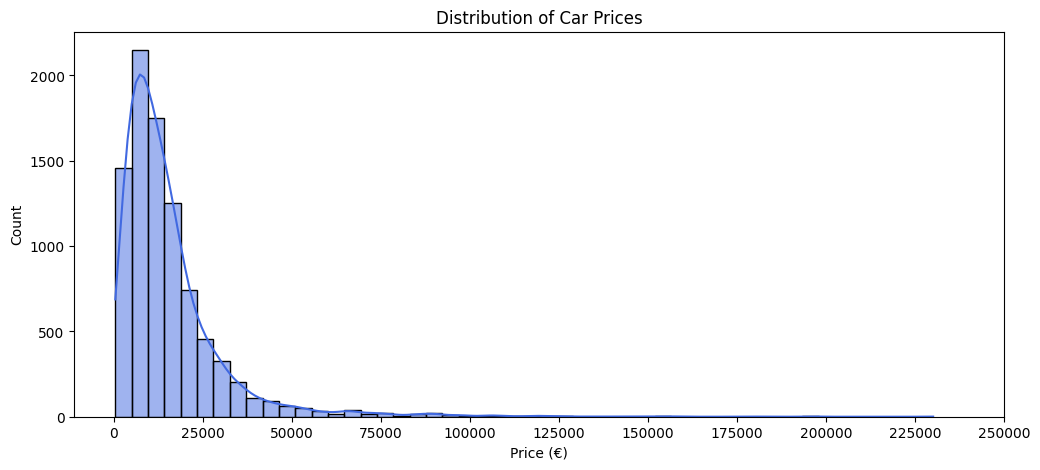

In [96]:
plt.figure(figsize=(12, 5))
sns.histplot(df['price'], bins=50, kde=True, color='royalblue')
plt.title("Distribution of Car Prices")
plt.xlabel("Price (€)")
plt.ylabel("Count")
plt.xticks(ticks=range(0, int(df['price'].max()) + 25000, 25000))
plt.show()

This plot shows the distribution of car prices in the dataset. We can see that almost all cars are priced between 10000 and 50000 euros but most of them are in the range of 0 to 20000 euros.

In [97]:
# Calculate the percentage of cars in different price ranges
percentage_0_10000 = df[df['price'].isin(range(0, 10000))].shape[0] / df.shape[0] * 100
percentage_10000_20000 = df[df['price'].isin(range(10000, 20000))].shape[0] / df.shape[0] * 100
percentage_20000_30000 = df[df['price'].isin(range(20000, 30000))].shape[0] / df.shape[0] * 100
percentage_30000_40000 = df[df['price'].isin(range(30000, 40000))].shape[0] / df.shape[0] * 100
percentage_40000_50000 = df[df['price'].isin(range(40000, 50000))].shape[0] / df.shape[0] * 100
percentage_above_50000 = df[df['price'] > 50000].shape[0] / df.shape[0] * 100

# Print these percentages in a nice table format
print(f"{'Price Range (€)':<20}{'Percentage':<10}")
print(f"{'-'*30}")
print(f"0 - 10,000         {percentage_0_10000:.2f}%")
print(f"10,000 - 20,000    {percentage_10000_20000:.2f}%")
print(f"20,000 - 30,000    {percentage_20000_30000:.2f}%")
print(f"30,000 - 40,000    {percentage_30000_40000:.2f}%")
print(f"40,000 - 50,000    {percentage_40000_50000:.2f}%")
print(f"Above 50,000       {percentage_above_50000:.2f}%")

Price Range (€)     Percentage
------------------------------
0 - 10,000         42.67%
10,000 - 20,000    34.77%
20,000 - 30,000    12.56%
30,000 - 40,000    4.79%
40,000 - 50,000    2.00%
Above 50,000       3.14%


Now, let's see how price and age of the car are related.

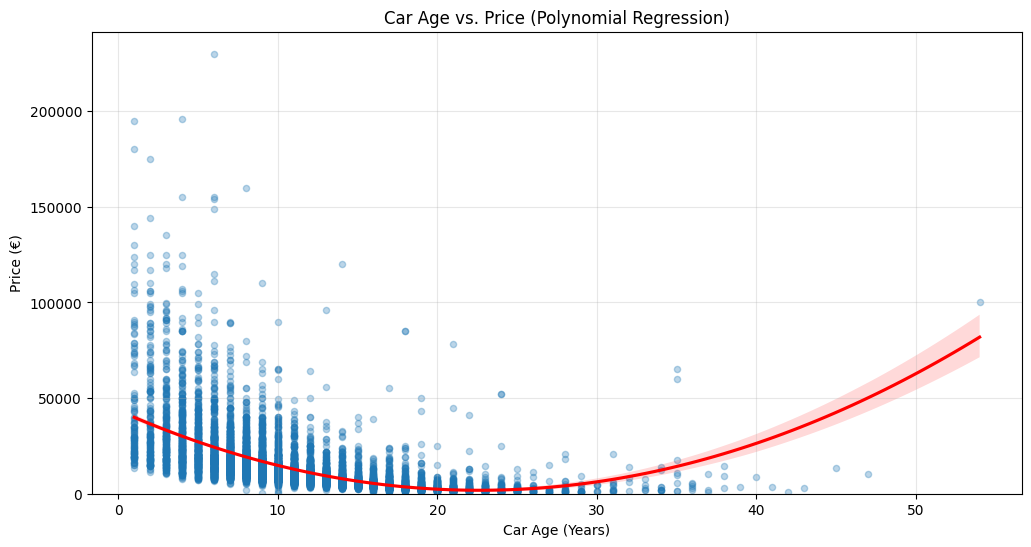

In [98]:
# Create figure
plt.figure(figsize=(12, 6))

# Create scatter plot with logarithmic regression
sns.regplot(
    x=2025 - df['year'], 
    y=df['price'],
    scatter_kws={
        'alpha': 0.3,  # Make dots more transparent
        's': 20  # Smaller dots
    },
    order=2,  # Use 2nd order polynomial fit
    line_kws={
        'color': 'red'
    }
)

# Customize plot
plt.title("Car Age vs. Price (Polynomial Regression)")
plt.xlabel("Car Age (Years)")
plt.ylabel("Price (€)")
plt.ylim(bottom=0)

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.show()

This plot shows the relationship between the age of the car and its price.
We can see that the price of cars is decreasing with age almost linearly.
However, after a certain age, some cars become more expensive again due to the fact that they are rare and/or in demand. This is the case with some oldtimers which can cost a fortune.

Now let's see how engine power and price are related, and how that corelates to engine displacement.

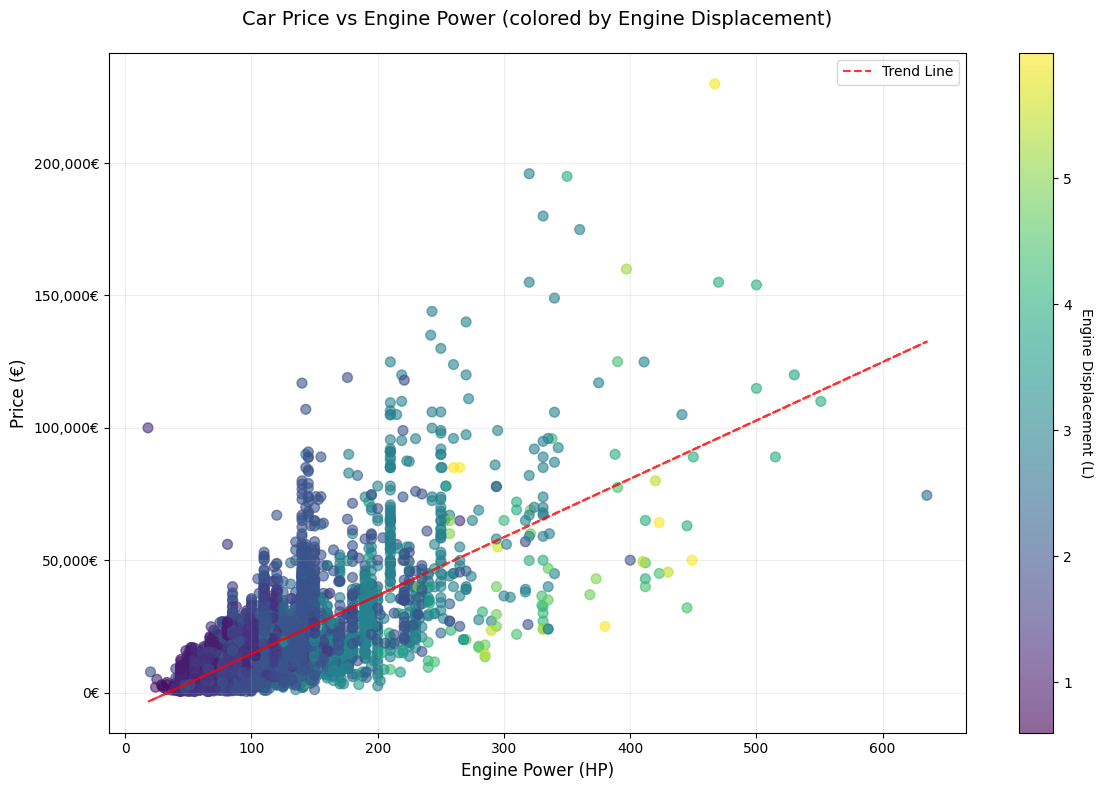

In [99]:
# Create figure with larger size
plt.figure(figsize=(12, 8))

# Create scatter plot with engine displacement as color
scatter = plt.scatter(
    x=df['engine_power'],
    y=df['price'],
    c=df['engine_displacement'],
    alpha=0.6,
    cmap='viridis',
    s=50
)

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Engine Displacement (L)', rotation=270, labelpad=15)

# Customize plot
plt.title("Car Price vs Engine Power (colored by Engine Displacement)", pad=20, size=14)
plt.xlabel("Engine Power (HP)", size=12)
plt.ylabel("Price (€)", size=12)

# Format y-axis to show thousands
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}€'))

# Add grid for better readability
plt.grid(True, alpha=0.2)

# Add trend line
z = np.polyfit(df['engine_power'], df['price'], 1)
p = np.poly1d(z)
plt.plot(df['engine_power'], p(df['engine_power']), "r--", alpha=0.8, label='Trend Line')

plt.legend()

# Adjust layout
plt.tight_layout()

plt.show()

Here we can see a clear relationship between engine power and price.
The more powerful the car, the more it costs.
Also, as expected, engine displacement is proportional to the engine power and price.

Let's see the brands distribution for the car listings in the dataset.

/var/folders/6f/hkscx_4j699g9wwrvk1s__hh0000gn/T/ipykernel_20803/3831040988.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




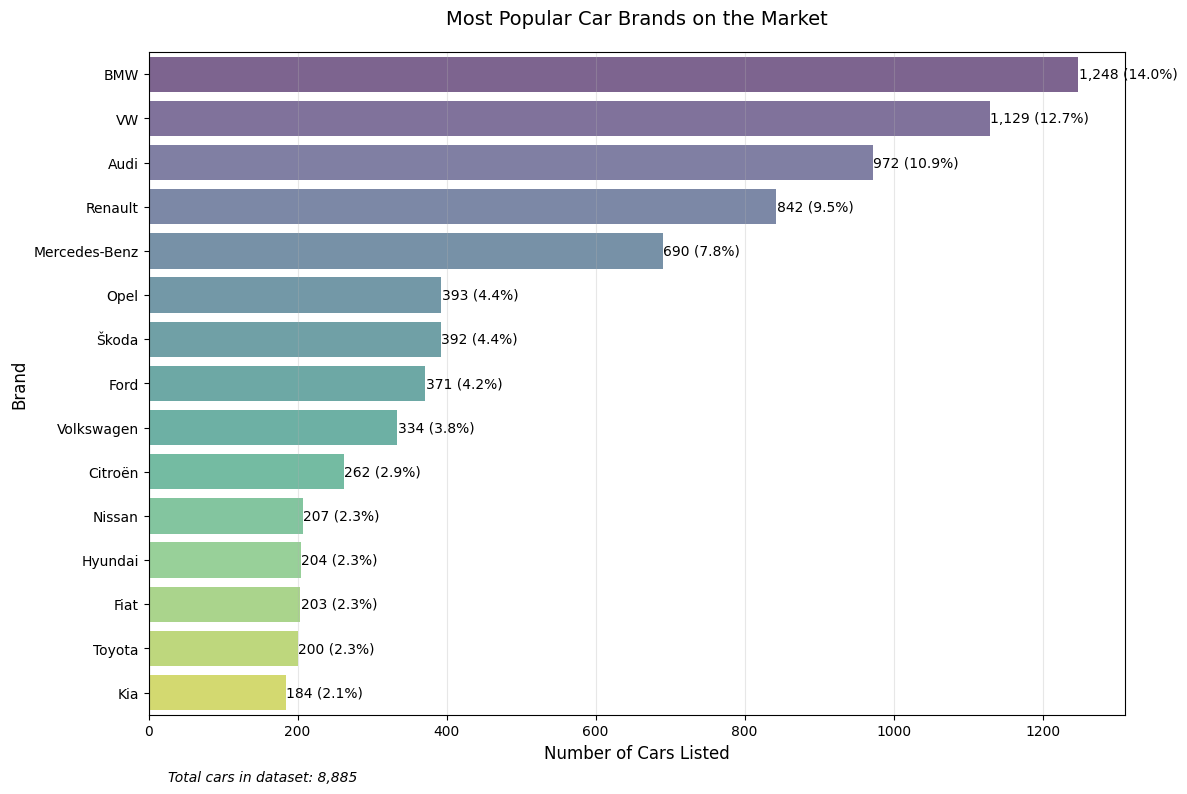

In [100]:
# Create figure with larger size
plt.figure(figsize=(12, 8))

# Get top 15 brands and their counts
top_brands = df['brand'].value_counts().head(15)
total_cars = len(df)

# Create bar plot
ax = sns.barplot(
    x=top_brands.values,
    y=top_brands.index,
    palette='viridis',
    alpha=0.7
)

# Add percentage labels to the bars
for i, v in enumerate(top_brands.values):
    percentage = (v / total_cars) * 100
    ax.text(
        v + 1, 
        i, 
        f'{v:,} ({percentage:.1f}%)', 
        va='center',
        fontsize=10
    )

# Customize plot
plt.title("Most Popular Car Brands on the Market", pad=20, size=14)
plt.xlabel("Number of Cars Listed", size=12)
plt.ylabel("Brand", size=12)

# Add grid for better readability
plt.grid(axis='x', alpha=0.3)

# Add total count in the corner
plt.text(
    0.02, -0.1, 
    f'Total cars in dataset: {total_cars:,}',
    transform=plt.gca().transAxes,
    fontsize=10,
    style='italic'
)

# Adjust layout
plt.tight_layout()

plt.show()

As expected, the most popular brands are the german ones.

Now let's see how many cars in the dataset have valid registration, how many are garage kept and how many provided the service book.

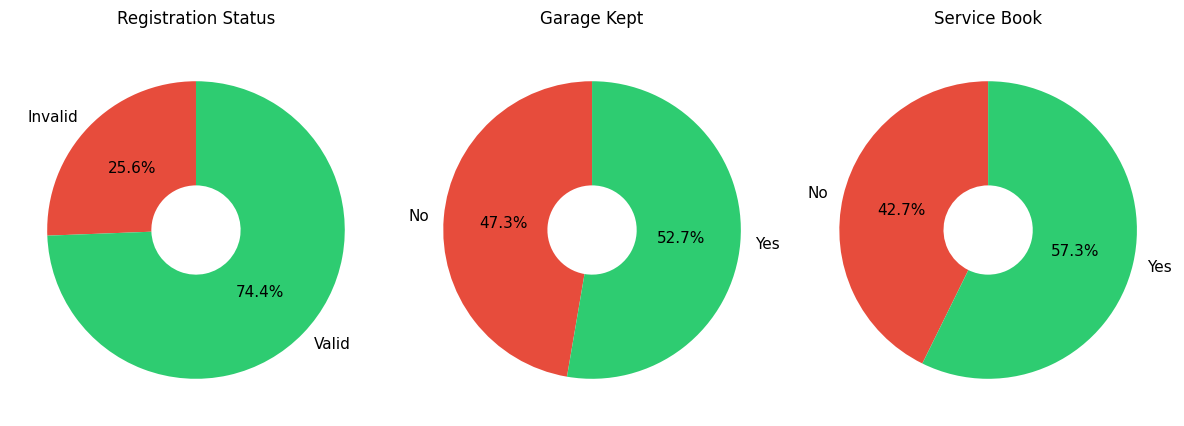


Car Characteristics Summary:
────────────────────────────────────────
Registration:    6,610 valid (74.4%)
Garage Kept:     4,682 cars (52.7%)
Service Book:    3,795 cars (42.7%)
────────────────────────────────────────
Total cars: 8,885


In [101]:
# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Common pie chart settings
pie_settings = {
    'autopct': lambda pct: f'{pct:.1f}%',
    'startangle': 90,
    'wedgeprops': {'width': 0.7},  # Create donut chart
    'textprops': {'fontsize': 11},
    'colors': ['#e74c3c', '#2ecc71']  # Red, Green
}

# 1. Registration Status
reg_counts = df['registration_until'].notna().value_counts()
ax1.pie(reg_counts.values[::-1], labels=['Invalid', 'Valid'], **pie_settings)
ax1.set_title('Registration Status', pad=15, fontsize=12)

# 2. Garage Kept Status
garage_counts = df['garage_kept'].value_counts()
ax2.pie(garage_counts.values[::-1], labels=['No', 'Yes'], **pie_settings)
ax2.set_title('Garage Kept', pad=15, fontsize=12)

# 3. Service Book Status
service_counts = df['service_book'].value_counts()
ax3.pie(service_counts.values[::-1], labels=['No', 'Yes'], **pie_settings)
ax3.set_title('Service Book', pad=15, fontsize=12)

plt.tight_layout()
plt.show()

# Print statistics in a more readable format
print("\nCar Characteristics Summary:")
print("─" * 40)
print(f"{'Registration:':<15} {reg_counts[True]:>6,} valid ({reg_counts[True]/len(df)*100:.1f}%)")
print(f"{'Garage Kept:':<15} {garage_counts[True]:>6,} cars ({garage_counts[True]/len(df)*100:.1f}%)")
print(f"{'Service Book:':<15} {service_counts[True]:>6,} cars ({service_counts[True]/len(df)*100:.1f}%)")
print("─" * 40)
print(f"Total cars: {len(df):,}")

Three out of four cars have valid registration, about half of them are garage kept a bit less than half of the owners provided the service book.

We can try to visualize the relationship between the characteristics of the cars in a parallel coordinates plot.
This obviously is very messy, but it gives an interesting overview of the data.


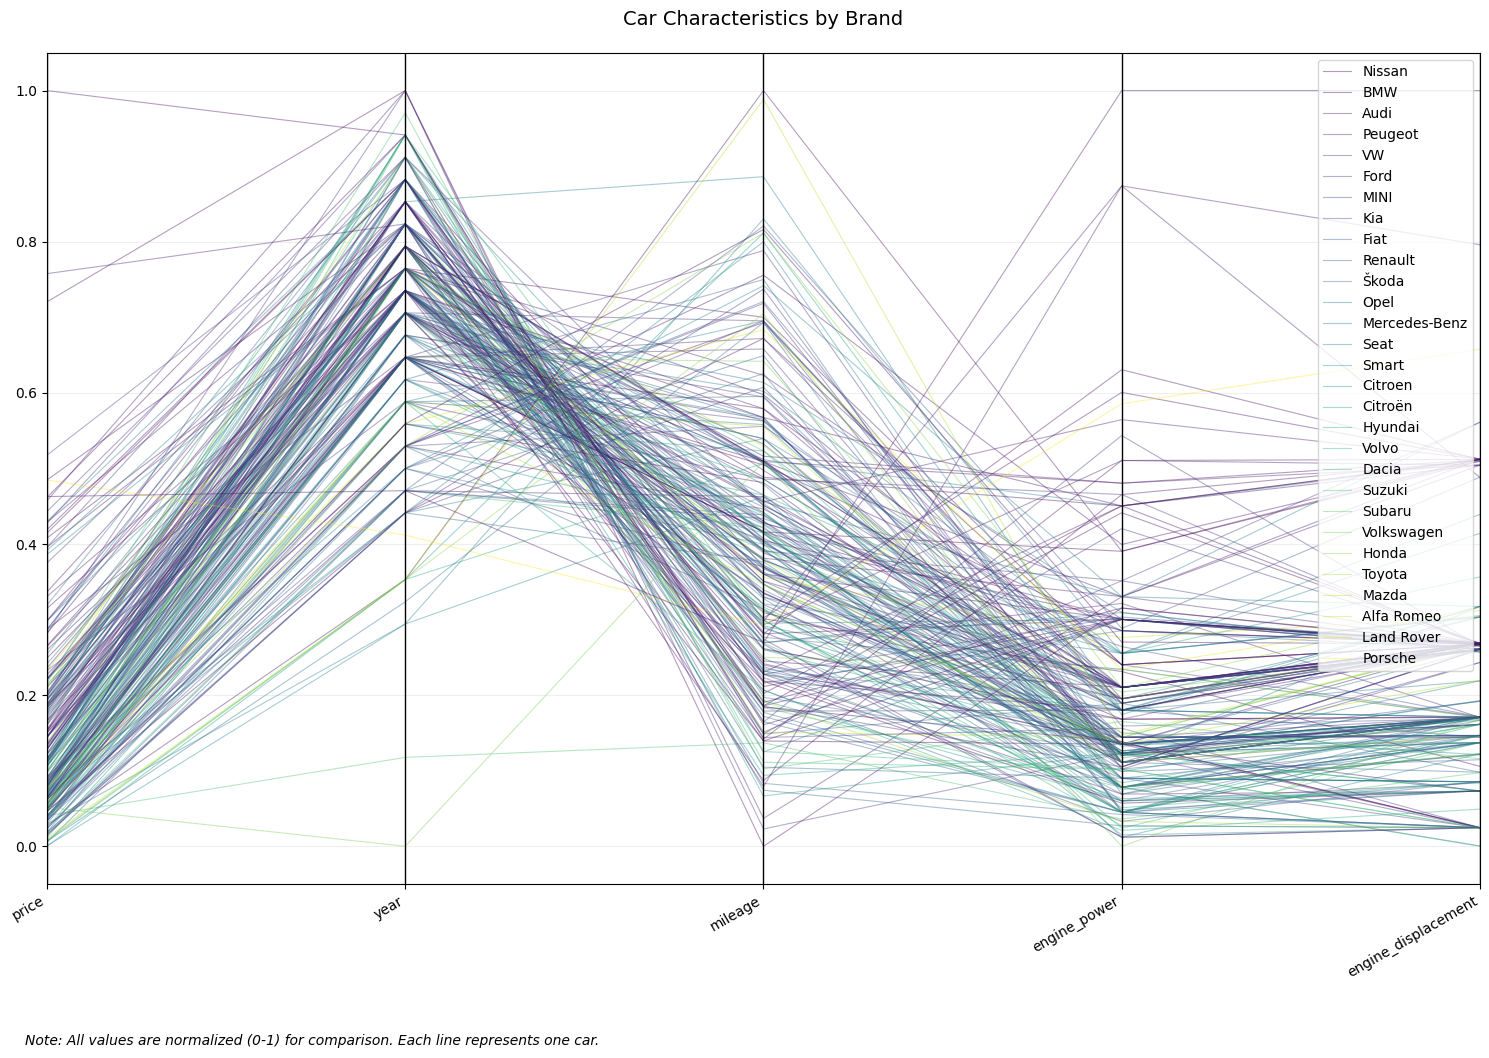


Sample Statistics:
────────────────────────────────────────
Price                Range: 800 - 91,990
Year                 Range: 1,990 - 2,024
Mileage              Range: 1,100 - 431,000
Engine Power         Range: 40 - 373
Engine Displacement  Range: 1 - 5
────────────────────────────────────────
Sample size: 250 cars
Number of brands: 29 unique brands


In [112]:
# import parallel_coordinates
from pandas.plotting import parallel_coordinates

# Create a sample with more data points but not too many to avoid clutter
df_sample = df.sample(250, random_state=23)

# Normalize the data for better visualization
def normalize(x):
    if x.dtype.kind in 'iufc':  # Only normalize numeric columns
        return (x - x.min()) / (x.max() - x.min())
    return x

# Select and prepare columns
numeric_cols = ['price', 'year', 'mileage', 'engine_power', 'engine_displacement']
df_norm = pd.DataFrame()

# Normalize numeric columns
for col in numeric_cols:
    df_norm[col] = normalize(df_sample[col])

# Add brand column (not normalized)
df_norm['brand'] = df_sample['brand']

# Create figure
plt.figure(figsize=(15, 10))

# Create parallel coordinates plot with a better color scheme
parallel_coordinates(
    df_norm, 
    class_column='brand',
    cols=numeric_cols,  # Only use numeric columns for parallel coordinates
    colormap='viridis',  # More pleasing color scheme
    alpha=0.4,           # More transparency
    linewidth=0.8        # Thinner lines
)

# Customize the plot
plt.title("Car Characteristics by Brand", pad=20, size=14)
plt.xticks(rotation=30, ha='right')
plt.grid(True, alpha=0.2)

# Add a brief explanation
plt.figtext(
    0.02, -0.05,
    "Note: All values are normalized (0-1) for comparison. Each line represents one car.",
    style='italic',
    fontsize=10
)

# Adjust layout
plt.tight_layout()

plt.show()

# Print some statistics about the sample
print("\nSample Statistics:")
print("─" * 40)
for col in numeric_cols:
    print(f"{col.replace('_', ' ').title():<20} Range: {df_sample[col].min():,.0f} - {df_sample[col].max():,.0f}")
print("─" * 40)
print(f"Sample size: {len(df_sample)} cars")
print(f"Number of brands: {df_sample['brand'].nunique()} unique brands")

Interactive 3D plot of the whole dataset.

In [103]:
import plotly.express as px
import plotly.io as pio

# Set the renderer
pio.renderers.default = "notebook"  # or try "browser" if notebook doesn't work

# Create 3D scatter plot
fig = px.scatter_3d(
    df,
    x='price',
    y='engine_power',
    z='mileage',
    color='brand',
    size='engine_displacement',
    hover_data=['year', 'fuel_consumption'],
    title='Interactive 3D Car Characteristics',
    opacity=0.7
)

# Update layout for better view
fig.update_layout(
    scene = dict(
        xaxis_title='Price (€)',
        yaxis_title='Engine Power (HP)',
        zaxis_title='Mileage (km)',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=1200,
    height=800,
    margin=dict(l=0, r=0, b=0, t=30)
)

# Try different ways to display the plot
try:
    fig.show()  # Default method
except:
    try:
        pio.show(fig)  # Alternative method 1
    except:
        fig.write_html("car_visualization.html")  # Alternative method 2 - saves to file
        print("Visualization saved to 'car_visualization.html'. Please open it in your browser.")

Visualization saved to 'car_visualization.html'. Please open it in your browser.


Heatmap of the correlation between the characteristics of the cars.
This confirms some of the relationships we saw in the previous plots.

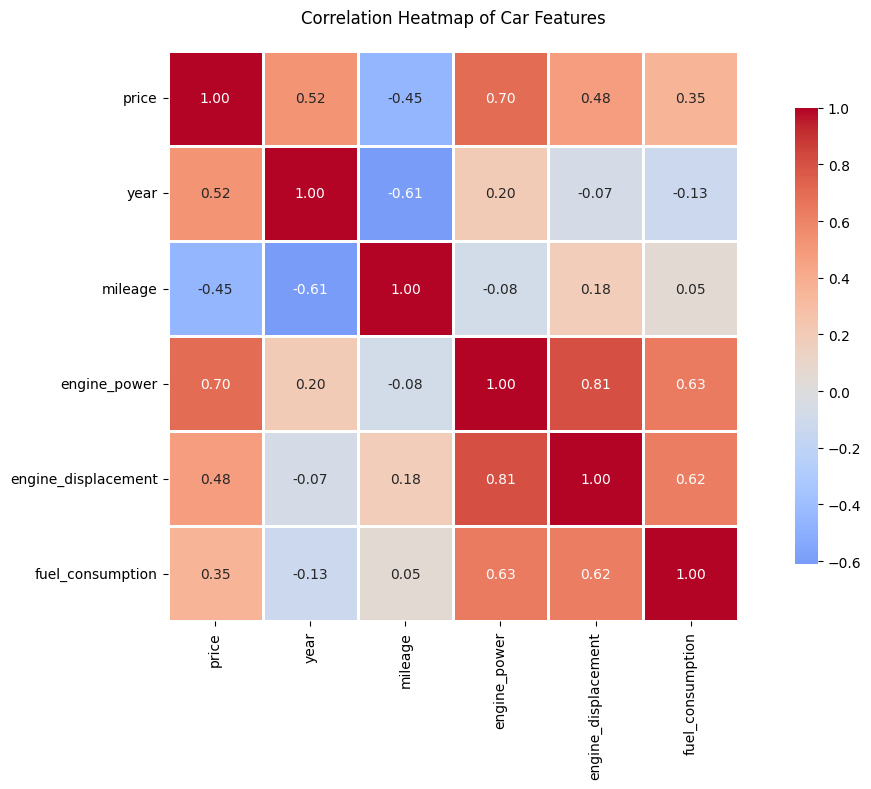

In [104]:
import seaborn as sns

# Create correlation matrix with selected features
features = ['price', 'year', 'mileage', 'engine_power', 'engine_displacement', 'fuel_consumption']
correlation_matrix = df[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    square=True,
    linewidths=2,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Car Features', pad=20)
plt.tight_layout()
plt.show()

On this heatmap we can see significant negative correlation between price and mileage, and mileage and year.
Let's visualize this, first the price vs mileage.

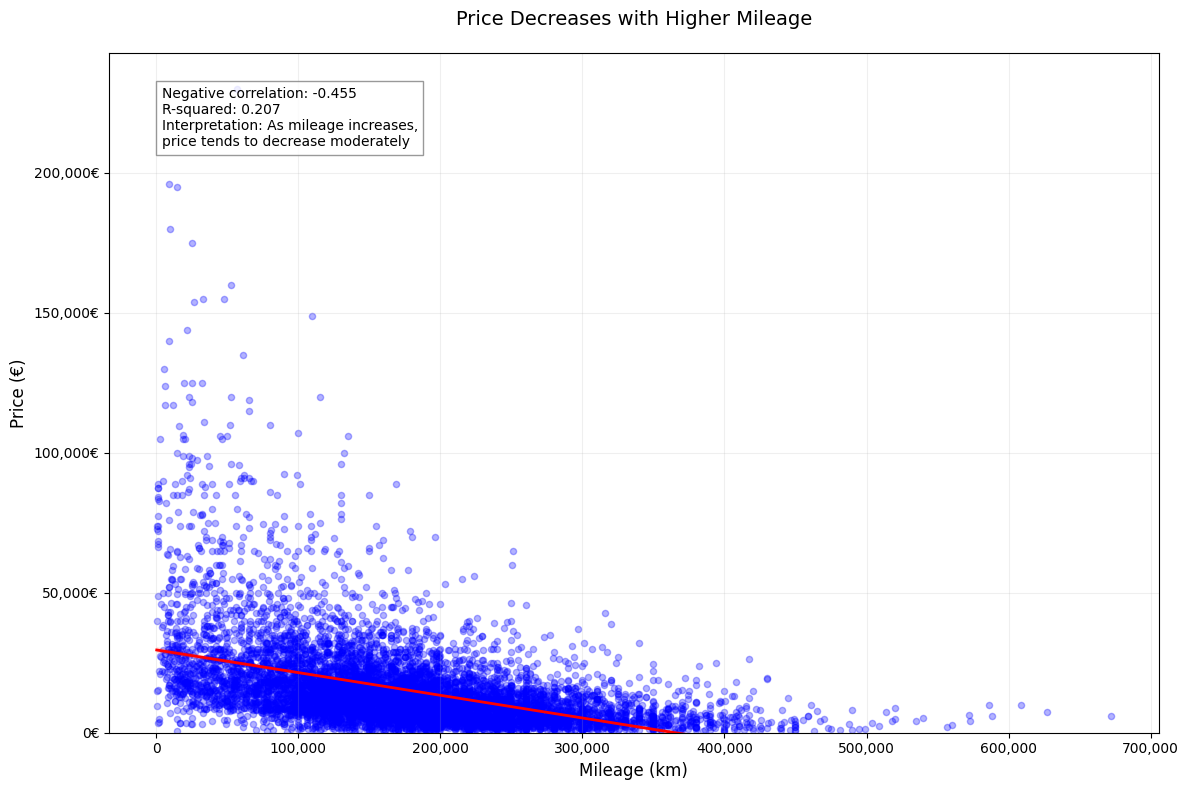


Interpretation of Results:
──────────────────────────────────────────────────
• Correlation of -0.455 indicates a moderate negative relationship
• About 20.7% (R-squared) of price variation can be explained by mileage
• The relationship is statistically significant (p-value ≈ 0)
• For every increase in mileage, there's a tendency for price to decrease

Key Statistics:
──────────────────────────────────────────────────
Number of cars: 8,885
Price range: 400.0€ - 230,000.0€
Mileage range: 401km - 672,000km


In [109]:
# import stats
from scipy import stats

# Create figure
plt.figure(figsize=(12, 8))

# Create scatter plot with regression line
sns.regplot(
    data=df,
    x='mileage',
    y='price',
    scatter_kws={
        'alpha': 0.3,
        's': 20,
        'color': 'blue'
    },
    line_kws={
        'color': 'red',
        'linewidth': 2
    }
)

# Calculate correlation coefficient and p-value
correlation, p_value = stats.pearsonr(df['mileage'], df['price'])
r_squared = correlation ** 2

# Add statistical information
stats_text = (
    f'Negative correlation: {correlation:.3f}\n'
    f'R-squared: {r_squared:.3f}\n'
    f'Interpretation: As mileage increases,\n'
    f'price tends to decrease moderately'
)

plt.text(
    0.05, 0.95, 
    stats_text,
    transform=plt.gca().transAxes,
    bbox=dict(
        facecolor='white',
        alpha=0.8,
        edgecolor='gray'
    ),
    verticalalignment='top'
)

# Customize plot
plt.title('Price Decreases with Higher Mileage', pad=20, size=14)
plt.xlabel('Mileage (km)', size=12)
plt.ylabel('Price (€)', size=12)

# Format axis labels
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}€'))

# Set y-axis minimum to 0
plt.ylim(bottom=0)

# Add grid
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Print interpretation
print("\nInterpretation of Results:")
print("─" * 50)
print("• Correlation of -0.455 indicates a moderate negative relationship")
print("• About 20.7% (R-squared) of price variation can be explained by mileage")
print("• The relationship is statistically significant (p-value ≈ 0)")
print("• For every increase in mileage, there's a tendency for price to decrease")
print("\nKey Statistics:")
print("─" * 50)
print(f"Number of cars: {len(df):,}")
print(f"Price range: {df['price'].min():,}€ - {df['price'].max():,}€")
print(f"Mileage range: {df['mileage'].min():,}km - {df['mileage'].max():,}km")

Now, let's see how year and mileage are related.

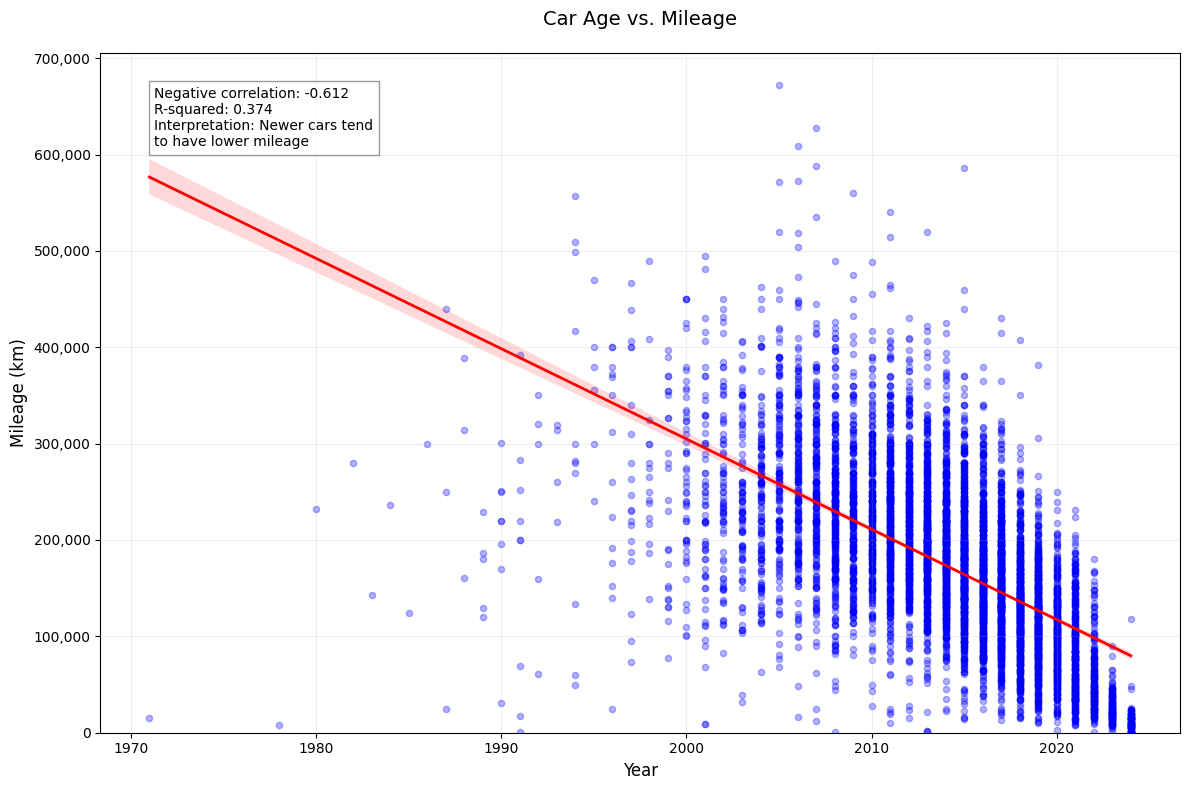


Interpretation of Results:
──────────────────────────────────────────────────
• Correlation of -0.612 indicates a strong negative relationship
• About 37.4% (R-squared) of mileage variation can be explained by year
• The relationship is statistically significant (p-value ≈ 0)
• As expected, newer cars tend to have significantly lower mileage

Key Statistics:
──────────────────────────────────────────────────
Number of cars: 8,885
Year range: 1971 - 2024
Mileage range: 401km - 672,000km

Average mileage by decade:
          mean  count
decade               
1970    11,350      2
1980   220,002     17
1990   259,474    118
2000   245,961   1555
2010   174,098   5902
2020    71,987   1291


In [110]:
# Create figure
plt.figure(figsize=(12, 8))

# Create scatter plot with regression line
sns.regplot(
    data=df,
    x='year',
    y='mileage',
    scatter_kws={
        'alpha': 0.3,
        's': 20,
        'color': 'blue'
    },
    line_kws={
        'color': 'red',
        'linewidth': 2
    }
)

# Calculate correlation coefficient and p-value
correlation, p_value = stats.pearsonr(df['year'], df['mileage'])
r_squared = correlation ** 2

# Add statistical information
stats_text = (
    f'Negative correlation: {correlation:.3f}\n'
    f'R-squared: {r_squared:.3f}\n'
    f'Interpretation: Newer cars tend\n'
    f'to have lower mileage'
)

plt.text(
    0.05, 0.95, 
    stats_text,
    transform=plt.gca().transAxes,
    bbox=dict(
        facecolor='white',
        alpha=0.8,
        edgecolor='gray'
    ),
    verticalalignment='top'
)

# Customize plot
plt.title('Car Age vs. Mileage', pad=20, size=14)
plt.xlabel('Year', size=12)
plt.ylabel('Mileage (km)', size=12)

# Format axis labels
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Set y-axis minimum to 0
plt.ylim(bottom=0)

# Add grid
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# Print interpretation
print("\nInterpretation of Results:")
print("─" * 50)
print(f"• Correlation of {correlation:.3f} indicates a strong negative relationship")
print(f"• About {(r_squared*100):.1f}% (R-squared) of mileage variation can be explained by year")
print("• The relationship is statistically significant (p-value ≈ 0)")
print("• As expected, newer cars tend to have significantly lower mileage")
print("\nKey Statistics:")
print("─" * 50)
print(f"Number of cars: {len(df):,}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print(f"Mileage range: {df['mileage'].min():,}km - {df['mileage'].max():,}km")
print(f"\nAverage mileage by decade:")
df['decade'] = (df['year'] // 10) * 10
decade_stats = df.groupby('decade')['mileage'].agg(['mean', 'count']).round(0)
print(decade_stats.to_string(float_format=lambda x: f"{x:,.0f}"))

---

# Conclusion

Throghout this project we have covered scraping the data from the web, storing it locally, cleaning and shaping it, and then finally visualizing it to get a better understanding of the data.

Visualizing the data gave us a lot of interesting insights, for example the distribution of car prices, positive correlation between engine power/displacement with price, and negative correlation between mileage and price/year. It is clear that the price is mostly impacted by engine power, year and mileage. 
We also confirmed that the german brands are the most popular ones. 

From all this we got a better understanding of the car market in Croatia and a very good foundation to build our ML model on. 
